# Developing the sensitivity test tools using the BNB 

## Defining the benchmark points

As this is aimed to be a comparison with the existing MicroBooNE limits, we define the same benchmark points as a starting point. They are as defined below:

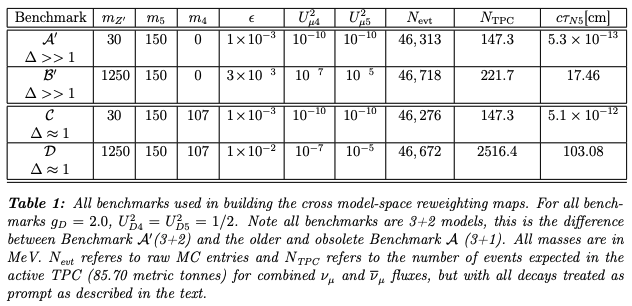

These are the parameters defined in the DarkNews $e^+e^-$ MOU, which were interested in comparing to. We should reproduce the $N_{TPC}$, from which we can then base our sensitivity testing.

In [1]:
import DarkNews as dn
from DarkNews import GenLauncher
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pyhf
from scipy import optimize

### Using the analysis tools defined in ToyAnalysis for the MicroBooNE example.
# We use these tools to make selections on the generated decays to be contained within the TPC.
import ToyAnalysis as ta
import ToyAnalysis.analysis as a
import ToyAnalysis.analysis_decay as an

In [7]:
neval = 1e4
experiment = 'microboone'
loglevel = 'WARNING'
HNL_type = 'dirac'
no_pelastic = True
decay_product = 'e+e-'

kwargs_a = {  
        'name': 'benchmark_a',
        'neval': neval,
        'HNLtype': HNL_type,
        'mzprime':0.030,
        'm5': 0.150,
        'm4': 0,
        'epsilon': 1e-3,
        "Umu4": 1e-5,
        "Umu5": 1e-5, 
        # 'unweighted_hep_events': 1000,
        # 'hep_unweight': True,
        'decay_product': decay_product,
        'experiment': experiment,
        'nopelastic': no_pelastic,
        'pandas': False,
        'loglevel': loglevel
        }

kwargs_b = {  
        'name': 'benchmark_b',
        'neval': neval,
        'HNLtype': HNL_type,
        'mzprime':1.250,
        'm5': 0.150,
        'm4': 0,
        'epsilon': 3e-3,
        "Umu4": 10**(-3.5),
        "Umu5": 10**(-2.5), 
        
        # 'unweighted_hep_events': 1000,
        # 'hep_unweight': True,
        'decay_product': decay_product,
        'experiment': experiment,
        'nopelastic': no_pelastic,
        'pandas': False,
        'loglevel': loglevel
        }

kwargs_c = {  
        'name': 'benchmark_c',
        'neval': neval,
        'HNLtype': HNL_type,
        'mzprime':0.03,
        'm5': 0.150,
        'm4': 0.107,
        'epsilon': 1e-3,
        "Umu4": 1e-5,
        "Umu5": 1e-5, 
        
        # 'unweighted_hep_events': 1000,
        # 'hep_unweight': True,
        'decay_product': decay_product,
        'experiment': experiment,
        'nopelastic': no_pelastic,
        'pandas': False,
        'loglevel': loglevel
        }

kwargs_d = {  
        'name': 'benchmark_d',
        'neval': neval,
        'HNLtype': HNL_type,
        'mzprime':1.250,
        'm5': 0.150,
        'm4': 0.107,
        'epsilon': 1e-2,
        "Umu4": 10**(-3.5),
        "Umu5": 10**(-2.5), 
        
        # 'unweighted_hep_events': 1000,
        # 'hep_unweight': True,
        'decay_product': decay_product,
        'experiment': experiment,
        'nopelastic': no_pelastic,
        'pandas': False,
        'loglevel': loglevel
        }

In [8]:
gen_object_A = GenLauncher(**kwargs_a)
gen_object_A.run()
benchmark_A = gen_object_A.df
gen_object_B = GenLauncher(**kwargs_b)
gen_object_B.run()
benchmark_B = gen_object_B.df
gen_object_C = GenLauncher(**kwargs_c)
gen_object_C.run() 
benchmark_C = gen_object_C.df
gen_object_D = GenLauncher(**kwargs_d)
gen_object_D.run()
benchmark_D = gen_object_D.df

### Using ToyAnalysis to get an idea of the expected signal rate

This is for a PoT and flux defined in src/DarkNews/include/microboone.txt.

Currently set at $6.8\times 10^{20}$ PoT.

In [9]:
### Using the analysis tools defined in ToyAnalysis for the MicroBooNE example.
# We use these tools to make selections on the generated decays to be contained within the TPC.
import ToyAnalysis as ta
import ToyAnalysis.analysis as a
import ToyAnalysis.analysis_decay as an

df1 = an.set_params(benchmark_A)

benchmark_A_decay = an.decay_selection(benchmark_A, l_decay_proper_cm = benchmark_A.attrs['N5_ctau0'], experiment='microboone')
benchmark_B_decay = an.decay_selection(benchmark_B, l_decay_proper_cm = benchmark_B.attrs['N5_ctau0'], experiment='microboone')
benchmark_C_decay = an.decay_selection(benchmark_C, l_decay_proper_cm = benchmark_C.attrs['N5_ctau0'], experiment='microboone')
benchmark_D_decay = an.decay_selection(benchmark_D, l_decay_proper_cm = benchmark_D.attrs['N5_ctau0'], experiment='microboone')

In [10]:
rate_A = sum(benchmark_A_decay.w_event_rate)
rate_B = sum(benchmark_B_decay.w_event_rate)
rate_C = sum(benchmark_C_decay.w_event_rate)
rate_D = sum(benchmark_D_decay.w_event_rate)

print(f'Rate A: {rate_A}')
print(f'Rate B: {rate_B}')
print(f'Rate C: {rate_C}')
print(f'Rate D: {rate_D}')

Rate A: 147.4631139412439
Rate B: 206.120529785438
Rate C: 143.69202153501112
Rate D: 1445.3011945614292


## Background rates
Base the background rate on the single bin rate given in the DarkNews BNB technote:
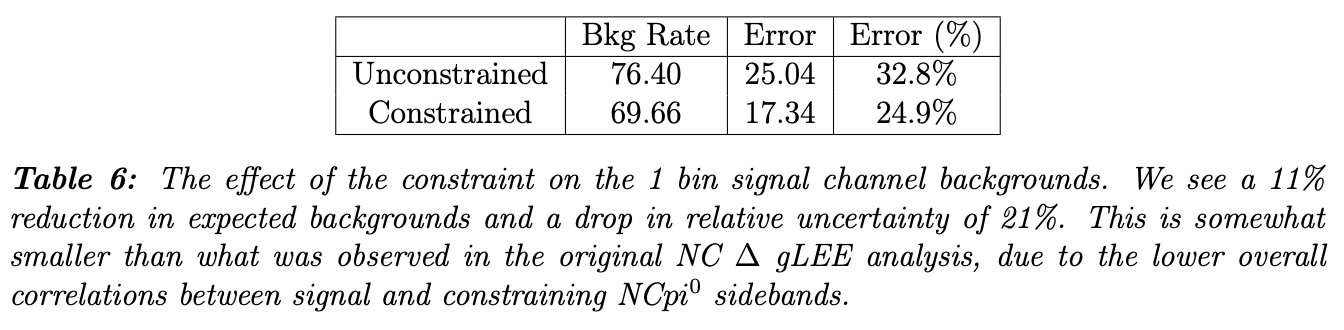

In [235]:
# # Unconstrained background
# bkg_events = 76.40
# bkg_events_tot_uncert = 25.04
# bkg_uncert = bkg_events_tot_uncert / bkg_events
# Constrained background
bkg_events = 69.66
bkg_events_tot_uncert = 17.34
bkg_uncert = bkg_events_tot_uncert / bkg_events

## Single bin histograms of signal and background

In [236]:
def get_expected_signal(df, efficiency = 0.05):
    return sum(df.w_event_rate) * efficiency

def get_tot_syst(err_arr):
    return np.sqrt(np.sum(err_arr**2))

def plot_single_bin_hist(sig, bkg, data, syst_uncert):

    data_err = np.sqrt(data)

    fig,ax = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(4,6),dpi=150)

    ax[0].step([0,1] , [bkg, bkg],  label = f'bkg = {bkg}')
    ax[0].step([0, 1] , [sig+bkg, sig+bkg], label = 'signal = {:.4}'.format(sig))


    # ax[0].errorbar([0.5], [data], yerr=[data_err], fmt='o', color='black', capsize=5, label = f'Data = {data}')

    ax[0].bar([0.5], [2 * syst_uncert], width = 1, bottom=[sig+bkg - syst_uncert], hatch='/', alpha=0.25, color='none', edgecolor='r', lw=0, label = 'syst. error')
    ax[0].set_ylim(0)
    ax[0].legend()
    ax[0].set_xlabel('Tot norm')
    ax[0].set_ylabel('Events')
    
    ax[1].step([0,1] , [1, 1], color='tab:blue')
    # ax[1].errorbar([0.5], [data/(bkg)], yerr=[data_err/(bkg)], fmt='o', color='black', capsize=5)
    ax[1].bar([0.5], 2*[syst_uncert/bkg]+syst_uncert/bkg, width = 1, bottom=[1 - syst_uncert/bkg], hatch='/', alpha=0.25, color='none', edgecolor='r', lw=0)
    ax[1].set_ylim(0., 2.)
    ax[1].set_ylabel('Data/MC')
    return fig, ax

/var/folders/wr/yb1fjkjn1mbg644j5v7f2tlm0000gp/T/ipykernel_58120/2359554345.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


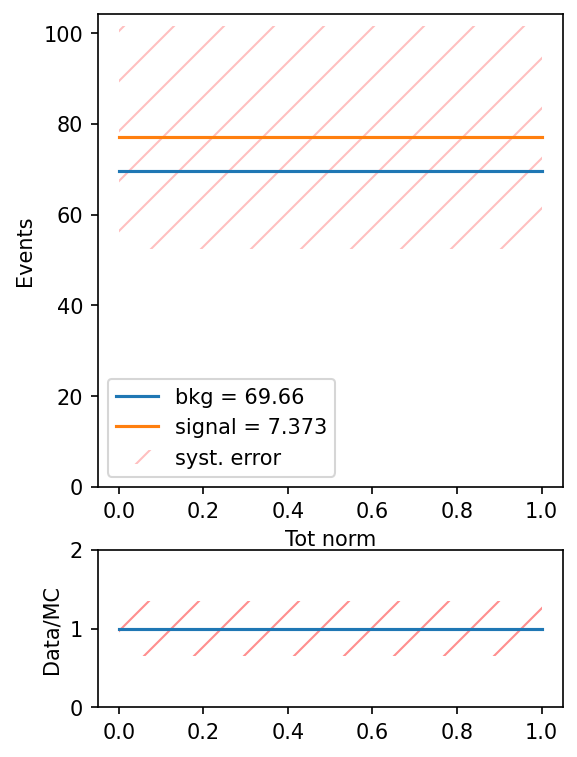

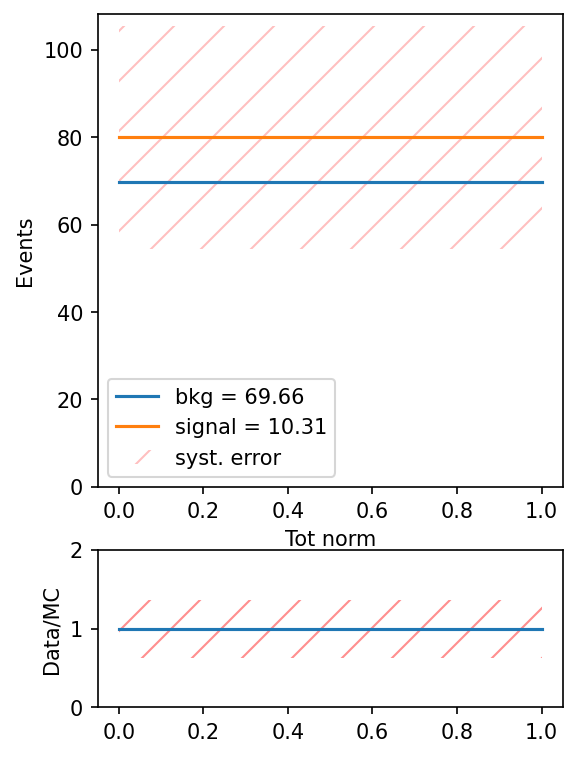

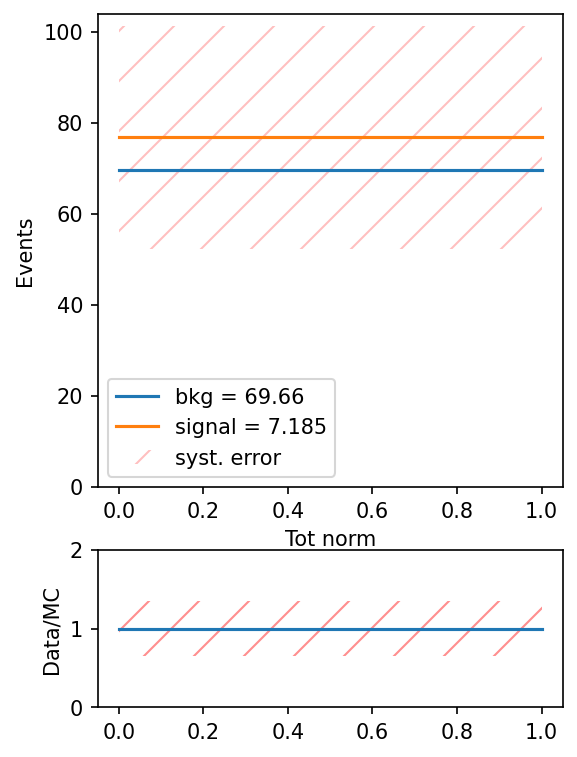

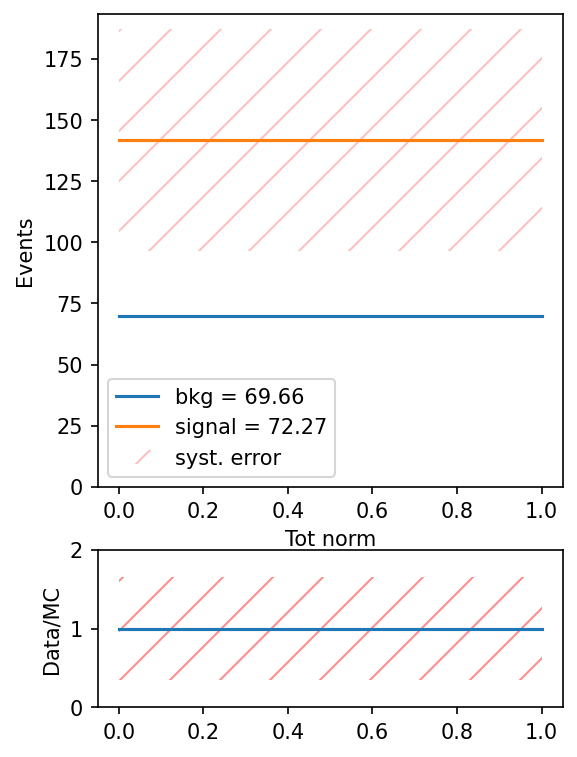

In [237]:
n_signal = get_expected_signal(benchmark_B_decay)

SIG_UNCERT = 0.2
SYST_UNCERT = get_tot_syst(np.array([bkg_uncert, SIG_UNCERT]))

benchmark_arr = [benchmark_A_decay, benchmark_B_decay, benchmark_C_decay, benchmark_D_decay]

for model in benchmark_arr:
    n_signal = get_expected_signal(model)
    syst_abs = (n_signal + bkg_events) * SYST_UNCERT
    fig, ax = plot_single_bin_hist(n_signal, bkg_events, bkg_events, syst_abs)    
    fig.show()

## Implementing a simple pyhf model for a single bin limit 

In [191]:
def create_model_dict_same(Total_dict, debug=False):
    """
    Creating a model where the uncertainties are all enveloped in one shapesys modifier for signal and bkg.
    The total errors are taken from \"TOT_SIGNAL_ERR\" and \"TOT_BKG_ERR\" respectively.
    """
    model_dict = {}
    
    for parameter_point in Total_dict:
        if(debug):print(parameter_point)
        model_dict[parameter_point] = pyhf.Model(
        {
      "channels": [
        {
          "name": "singlechannel",
          "samples": [
            {
              "name": "signal",
              "data": Total_dict[parameter_point]['TOT_SIGNAL_VALS'],
              "modifiers": [
                {"name": "mu", "type": "normfactor", "data": None, }, #This is the scaling which is to be calculated
                {"name": "uncorr_siguncrt", "type": "shapesys", "data": Total_dict[parameter_point]["TOT_SIGNAL_ERR"]}
              ]
            },
            {
              "name": "background",
              "data": Total_dict[parameter_point]['TOT_BKG_VALS'],
              "modifiers": [
                {"name": "uncorr_bkguncrt", "type": "shapesys", "data": Total_dict[parameter_point]["TOT_BKG_ERR"]}
              ]
            }
          ]
        }
      ],
      "parameters": [
            {
                "name": "mu",
                "bounds": [[0, 1000000]],
            }
      ],

    }
    )
    return model_dict

In [15]:
benchmark_A_decay.attrs

{'experiment': <DarkNews.detector.Detector at 0x3063afc40>,
 'model': <DarkNews.model.ThreePortalModel at 0x3061df340>,
 'N5_ctau0': 5.315009632925354e-13,
 'data_path': PosixPath('data/microboone/3plus2/m5_0.15_m4_0_mzprime_0.03_dirac')}

In [16]:
Total_dict = {}

names = ['benchmark_A', 'benchmark_B', 'benchmark_C', 'benchmark_D']
i = 0
for model in benchmark_arr:
    
    n_signal = get_expected_signal(model)
    syst_abs = (n_signal + bkg_events) * SYST_UNCERT

    
    Total_dict[names[i]] = {
        'data': [bkg_events],
        'TOT_SIGNAL_VALS': [n_signal],
        'TOT_BKG_VALS': [bkg_events],
        'TOT_SIGNAL_ERR': [syst_abs],
        'TOT_BKG_ERR': [bkg_events_tot_uncert]
    }
    i+=1

model_dict = create_model_dict_same(Total_dict)
DATA_OBS_dict = {}

for model in model_dict:
    init_pars = model_dict[model].config.suggested_init()
    model_dict[model].expected_actualdata(init_pars) #signal plus bkg

    bkg_pars = init_pars.copy()
    bkg_pars[model_dict[model].config.poi_index] = 0
    model_dict[model].expected_actualdata(bkg_pars) #bkg only
    list_keys = list(Total_dict[model].keys())

    DATA_OBS_dict[model] = Total_dict[model]['TOT_BKG_VALS']+model_dict[model].config.auxdata
    
    model_dict[model].logpdf(pars=bkg_pars, data=DATA_OBS_dict[model])


In [17]:
obs_limit_dict = {}
exp_limits_dict = {}
CL_level = 0.95

for model in model_dict:
    poi_values = np.linspace(0,2,100)

    print("Max value is " + str(max(poi_values)))
    print("Min value is " + str(min(poi_values)))
    print("Next value is " + str(poi_values[1]))
    print("Next value is " + str(poi_values[2]) + "\n")

    obs_limit_dict[model], exp_limits_dict[model], (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
        DATA_OBS_dict[model], model_dict[model], poi_values, level=CL_level, return_results=True
    )

    print(f"Upper limit {model}MeV (obs): μ = {obs_limit_dict[model]:.6f}")
    print(f"Upper limit {model}MeV (exp): μ = {exp_limits_dict[model][2]:.6f}" + "\n")

Max value is 2.0
Min value is 0.0
Next value is 0.020202020202020204
Next value is 0.04040404040404041

Upper limit benchmark_AMeV (obs): μ = 0.166695
Upper limit benchmark_AMeV (exp): μ = 0.166695

Max value is 2.0
Min value is 0.0
Next value is 0.020202020202020204
Next value is 0.04040404040404041

Upper limit benchmark_BMeV (obs): μ = 0.118096
Upper limit benchmark_BMeV (exp): μ = 0.118096

Max value is 2.0
Min value is 0.0
Next value is 0.020202020202020204
Next value is 0.04040404040404041

Upper limit benchmark_CMeV (obs): μ = 0.171255
Upper limit benchmark_CMeV (exp): μ = 0.171255

Max value is 2.0
Min value is 0.0
Next value is 0.020202020202020204
Next value is 0.04040404040404041

Upper limit benchmark_DMeV (obs): μ = 0.016650
Upper limit benchmark_DMeV (exp): μ = 0.016650



## Defining the first phase space

![Screenshot 2024-05-13 at 12.12.39.png](<attachment:Screenshot 2024-05-13 at 12.12.39.png>)

These are the first limits we should look to compare to.

We want to tune the initial values of Umu5 so that our pyhf behaves well.
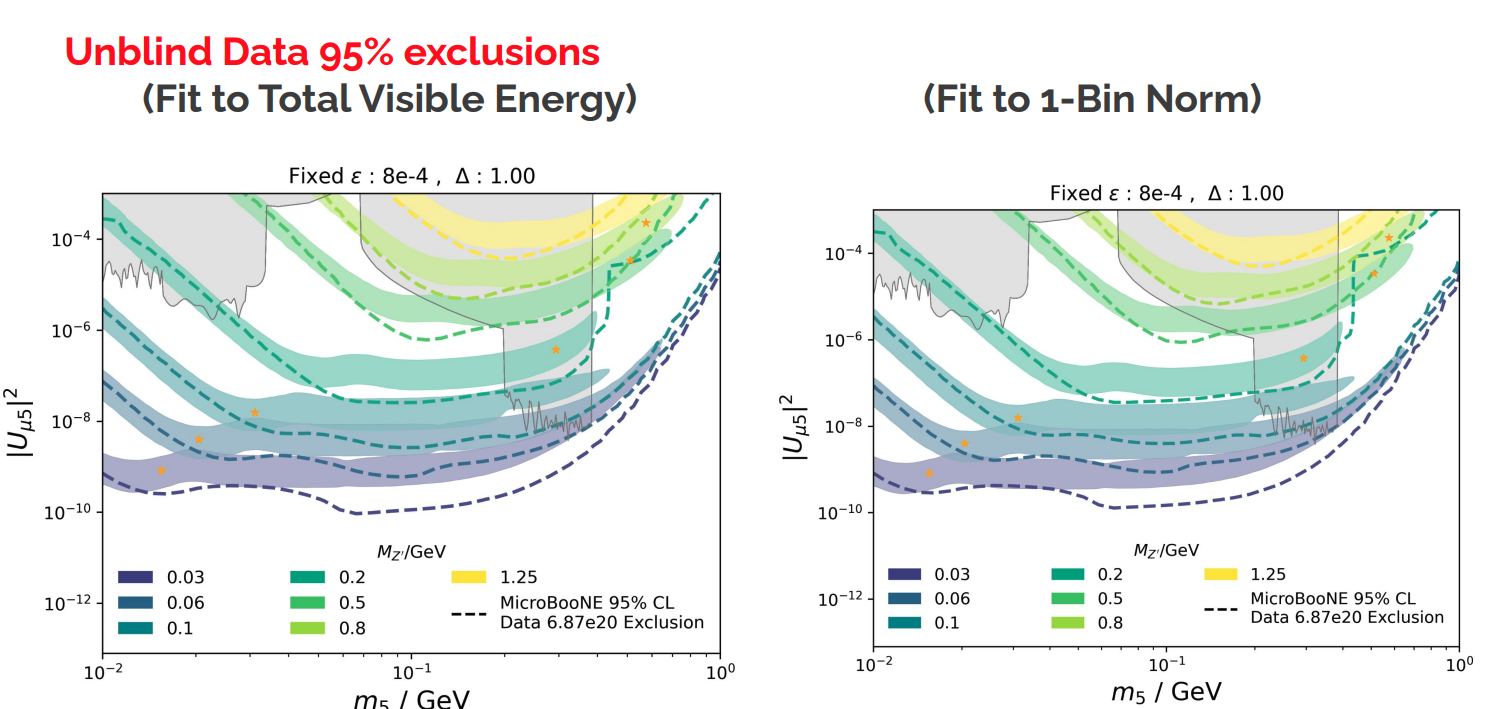

In [192]:
epsilon = 8e-4
mzprime_arr = [0.030, 0.06, 0.1, 0.2, 0.5, 0.8, 1.25]
m5_arr = np.linspace(-1.4,0, 10)
m5_arr = 10**m5_arr
# m5_arr = np.linspace(0.01, 1, 10)
Umu5 = 1e-2
delta = 1

In [193]:
def get_m4(m5, delta):
    return m5/(1 + delta)

In [194]:
neval = 1e4
experiment = 'microboone'
loglevel = 'WARNING'
HNL_type = 'dirac'
no_pelastic = True
decay_product = 'e+e-'



kwargs = {  
        'neval': neval,
        'HNLtype': HNL_type,
        'mzprime': mzprime_arr[-1],
        # 'm5': 0.150,
        # 'm4': 0,
        'epsilon': epsilon,
        "Umu4": Umu5,
        "Umu5": Umu5, 
        # 'unweighted_hep_events': 1000,
        # 'hep_unweight': True,
        'decay_product': decay_product,
        'experiment': experiment,
        'nopelastic': no_pelastic,
        'pandas': False,
        'loglevel': loglevel
        }

df_dict = {}

for m5 in m5_arr:
        m4 = get_m4(m5, delta)
        print("m5: {:.3}, m4: {:.3}".format(m5, m4))

        kwargs['m4'] = m4
        kwargs['m5'] = m5

        gen_object = GenLauncher(**kwargs)
        gen_object.run()

        df = gen_object.df
        df = an.set_params(df)

        df_decay = an.decay_selection(df, l_decay_proper_cm = df.attrs['N5_ctau0'], experiment='microboone')

        rate = sum(df_decay.w_event_rate)
        print(f'Rate: {rate}')
        print()
        df_dict['m5_{:.3}'.format(m5)] = df_decay


m5: 0.0398, m4: 0.0199
Directory tree for this run already exists. Overriding it.
Rate: 0.016324357842029194

m5: 0.057, m4: 0.0285
Directory tree for this run already exists. Overriding it.
Rate: 0.14189536480903914

m5: 0.0815, m4: 0.0407
Directory tree for this run already exists. Overriding it.
Rate: 1.2397411196049288

m5: 0.117, m4: 0.0583
Directory tree for this run already exists. Overriding it.
Rate: 9.404163766638826

m5: 0.167, m4: 0.0834
Directory tree for this run already exists. Overriding it.
Rate: 62.92363803862339

m5: 0.239, m4: 0.119
Directory tree for this run already exists. Overriding it.
Rate: 224.83569051845623

m5: 0.341, m4: 0.171
Directory tree for this run already exists. Overriding it.
Rate: 221.431533779582

m5: 0.489, m4: 0.244
Directory tree for this run already exists. Overriding it.
Rate: 70.43007436310543

m5: 0.699, m4: 0.349
Directory tree for this run already exists. Overriding it.
Rate: 6.6888278732445485

m5: 1.0, m4: 0.5
Directory tree for this 

In [195]:
Total_dict = {}

bkg_events = 76.40
bkg_events_tot_uncert = 25.04
bkg_uncert = bkg_events_tot_uncert / bkg_events

SIG_UNCERT = 0.2
SYST_UNCERT = get_tot_syst(np.array([bkg_uncert, SIG_UNCERT]))

for mass_point in df_dict:
    n_signal = get_expected_signal(df_dict[mass_point])
    syst_abs = (n_signal + bkg_events) * SYST_UNCERT

    Total_dict[mass_point] = {
        'data': [bkg_events],
        'TOT_SIGNAL_VALS': [n_signal],
        'TOT_BKG_VALS': [bkg_events],
        'TOT_SIGNAL_ERR': [syst_abs],
        'TOT_BKG_ERR': [bkg_events_tot_uncert]
    }

model_dict = create_model_dict_same(Total_dict)
DATA_OBS_dict = {}

for model in model_dict:
    init_pars = model_dict[model].config.suggested_init()
    model_dict[model].expected_actualdata(init_pars) #signal plus bkg

    bkg_pars = init_pars.copy()
    bkg_pars[model_dict[model].config.poi_index] = 0
    model_dict[model].expected_actualdata(bkg_pars) #bkg only
    list_keys = list(Total_dict[model].keys())

    DATA_OBS_dict[model] = Total_dict[model]['TOT_BKG_VALS']+model_dict[model].config.auxdata
    
    model_dict[model].logpdf(pars=bkg_pars, data=DATA_OBS_dict[model])

In [238]:
obs_limit_dict = {}
exp_limits_dict = {}
CL_level = 0.95

for model in model_dict:
    poi_values = np.linspace(0,5,100)

    print("Max value is " + str(max(poi_values)))
    print("Min value is " + str(min(poi_values)))
    print("Next value is " + str(poi_values[1]))
    print("Next value is " + str(poi_values[2]) + "\n")

    obs_limit_dict[model], exp_limits_dict[model], (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
        DATA_OBS_dict[model], model_dict[model], poi_values, level=CL_level, return_results=True
    )

    print(f"Upper limit {model} GeV (obs): μ = {obs_limit_dict[model]:.6f}")
    print(f"Upper limit {model} GeV (exp): μ = {exp_limits_dict[model][2]:.6f}" + "\n")

Max value is 5.0
Min value is 0.0
Next value is 0.050505050505050504
Next value is 0.10101010101010101

Upper limit m5_0.0398 GeV (obs): μ = 5.000000
Upper limit m5_0.0398 GeV (exp): μ = 5.000000

Max value is 5.0
Min value is 0.0
Next value is 0.050505050505050504
Next value is 0.10101010101010101

Upper limit m5_0.057 GeV (obs): μ = 5.000000
Upper limit m5_0.057 GeV (exp): μ = 5.000000

Max value is 5.0
Min value is 0.0
Next value is 0.050505050505050504
Next value is 0.10101010101010101

Upper limit m5_0.0815 GeV (obs): μ = 5.000000
Upper limit m5_0.0815 GeV (exp): μ = 5.000000

Max value is 5.0
Min value is 0.0
Next value is 0.050505050505050504
Next value is 0.10101010101010101

Upper limit m5_0.117 GeV (obs): μ = 5.000000
Upper limit m5_0.117 GeV (exp): μ = 5.000000

Max value is 5.0
Min value is 0.0
Next value is 0.050505050505050504
Next value is 0.10101010101010101

Upper limit m5_0.167 GeV (obs): μ = 0.628029
Upper limit m5_0.167 GeV (exp): μ = 0.628029

Max value is 5.0
Min 

In [239]:
exp_limit = [] #entry 2
exp_1sig_up = [] #entry 3
exp_1sig_down = [] #entry 1
exp_2sig_up = [] #entry 4
exp_2sig_down = [] #entry 0
obs_limit = []

for mass_point in obs_limit_dict:
    Umu2 = Umu5**2

    #N events scales with mixing angle squared
    obs_limit.append(Umu2*obs_limit_dict[mass_point])
    exp_limit.append(Umu2*(exp_limits_dict[mass_point][2]))

    exp_1sig_up.append(Umu2*(exp_limits_dict[mass_point][3]))
    exp_2sig_up.append(Umu2*(exp_limits_dict[mass_point][4]))
    exp_1sig_down.append(Umu2*(exp_limits_dict[mass_point][1]))
    exp_2sig_down.append(Umu2*(exp_limits_dict[mass_point][0]))

In [240]:
def plot_against_limits(approx_limits_dict, mass_point_arr, ):

    BNB_limits = np.genfromtxt('data/BNB_Limits/003_050_125.csv', delimiter=',', skip_header=2)
    limit_003 = BNB_limits[:,:2]
    limit_050 = BNB_limits[:,2:4]
    limit_125 = BNB_limits[:,4:]

    plt.plot(limit_003[:,0],limit_003[:,1],label="BNB, M$_{Z'}$=0.03 GeV",color='C0')
    plt.plot(limit_050[:,0],limit_050[:,1],label="BNB, M$_{Z'}$=0.50 GeV",color='C1')
    plt.plot(limit_125[:,0],limit_125[:,1],label="BNB, M$_{Z'}$=1.25 GeV",color='C2')    

    for key in approx_limits_dict:
        limits = approx_limits_dict[key]
        obs_limit, exp_limit, exp_1sig_up, exp_1sig_down, exp_2sig_up, exp_2sig_down = limits
        plt.plot(mass_point_arr, exp_limit, lw=2,ls='--',color='red',label='Expected, M$_{Z\'}$ = '+key)
        plt.fill_between(mass_point_arr,np.array(exp_2sig_down),np.array(exp_2sig_up),color='yellow')
        plt.fill_between(mass_point_arr,np.array(exp_1sig_down),np.array(exp_1sig_up),color='lightgreen')

    plt.fill_between([0],[0],[0],color='yellow',label=r'Exp. 2$\sigma$')
    plt.fill_between([0],[0],[0],color='lightgreen',label=r'Exp. 1$\sigma$')

    plt.legend(prop={'size': 8}, loc="lower left",ncol=3)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-2,1e0)
    plt.ylim(1e-13,1e-3)
    plt.show()  


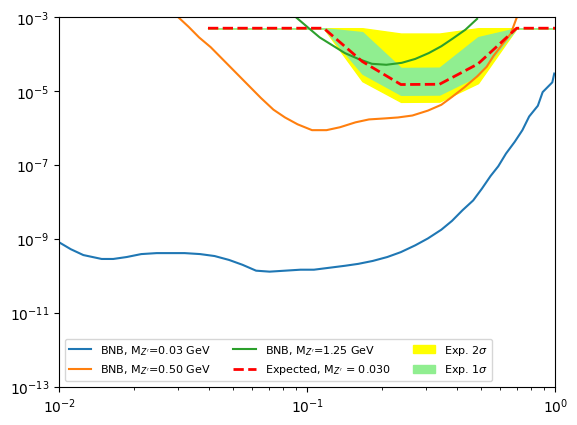

In [241]:
approx_limits_dict = {}
approx_limits_dict['0.030'] = [obs_limit, exp_limit, exp_1sig_up, exp_1sig_down, exp_2sig_up, exp_2sig_down]

plot_against_limits(approx_limits_dict, m5_arr)

(1e-13, 0.001)

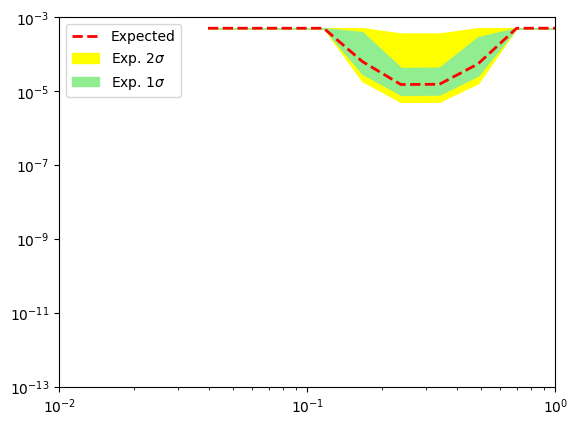

In [243]:
plt.plot(m5_arr, exp_limit, lw=2,ls='--',color='red',label='Expected')
plt.fill_between(m5_arr,np.array(exp_2sig_down),np.array(exp_2sig_up),color='yellow',label=r'Exp. 2$\sigma$')
plt.fill_between(m5_arr,np.array(exp_1sig_down),np.array(exp_1sig_up),color='lightgreen',label=r'Exp. 1$\sigma$')


plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2,1e0)
plt.ylim(1e-13,1e-3)

## Optimizing the value of |$U_{\mu5}$|

In [245]:
TARGET = 10 # Old: 100

def get_approx_observed_rate(Umu5, m5, delta, mzprime):
    neval = 1e3
    experiment = 'microboone'
    loglevel = 'WARNING'
    HNL_type = 'dirac'
    no_pelastic = True
    decay_product = 'e+e-'
    epsilon = 8e-4
    m4 = get_m4(m5, delta)

    kwargs = {  
            'neval': neval,
            'HNLtype': HNL_type,
            'mzprime': mzprime,
            'm5': m5,
            'm4': m4,
            'epsilon': epsilon,
            "Umu4": Umu5,
            "Umu5": Umu5, 
            # 'unweighted_hep_events': 1000,
            # 'hep_unweight': True,
            'decay_product': decay_product,
            'experiment': experiment,
            'nopelastic': no_pelastic,
            'pandas': False,
            'loglevel': loglevel
            }

    gen_object = GenLauncher(**kwargs)
    gen_object.run()

    df = gen_object.df
    df = an.set_params(df)
    df_decay = an.decay_selection(df, l_decay_proper_cm = df.attrs['N5_ctau0'], experiment='microboone')

    return sum(df_decay.w_event_rate)

def get_Umu5_values(mass_point_arr, delta, mzprime, steps = 25):

        Umu5_vals = []
        starting_point_arr = np.linspace(-6, 0, steps)
        Umu5_arr = 10**starting_point_arr

        for m5 in mass_point_arr:
                rate_arr = []
                for Umu5 in Umu5_arr:
                        rate = get_approx_observed_rate(Umu5, m5, delta, mzprime)
                        rate_arr.append(rate)
                label = 'm5 {:.3}'.format(m5)
                
                index = np.searchsorted(rate_arr, TARGET, side='right')-1
        
                rate = rate_arr[index]
                
                while  np.isnan(rate) and index > 0:
                        index -= 1
                        rate = rate_arr[index]
                print(rate)

                Umu5_vals.append(Umu5_arr[index])

        return Umu5_vals

In [204]:
mass_point_arr = np.linspace(-2,-0.0001, 10)
mass_point_arr = 10**mass_point_arr


mzprime = 0.030 # [0.5, 1.25]
mz_prime_arr = [0.030, 0.5, 1.25]
delta = 1 


first_it = True   
step = 10
for mzprime in mz_prime_arr:
    if first_it == True:
        Umu5_all = get_Umu5_values(mass_point_arr, delta, mzprime, steps = step)
        first_it = False
        continue
    
    Umu5_vals = get_Umu5_values(mass_point_arr, delta, mzprime, steps = step)
    Umu5_all = np.vstack((Umu5_all, Umu5_vals))

save_arr = np.vstack([mass_point_arr, Umu5_all])
save_arr_final = np.hstack([np.array([[0]+mz_prime_arr]).T, save_arr])



Directory tree for this run already exists. Overriding it.
Directory tree for this run already exists. Overriding it.
Directory tree for this run already exists. Overriding it.
Directory tree for this run already exists. Overriding it.
Directory tree for this run already exists. Overriding it.
Directory tree for this run already exists. Overriding it.
Directory tree for this run already exists. Overriding it.


KeyboardInterrupt: 

In [165]:
confirm_save = False
if confirm_save == True:
    np.savetxt('Umu5_vals.txt', save_arr_final)



In [205]:
Umu5_mass_arr = np.genfromtxt('Umu5_vals.txt')
mass_point_arr = Umu5_mass_arr[0][1:]
mz_prime_arr = Umu5_mass_arr[1:,0]
Umu5_arr = Umu5_mass_arr[1:,1:]

## Plotting limits across multiple $M_{Z'}$ values

In [251]:
def get_df_dict(mass_point_arr, Umu5_vals, kwargs):
        df_dict = {}

        for i, m5 in enumerate(mass_point_arr):
                rate = np.nan
                Umu5 = Umu5_vals[i]
                Umu4 = Umu5

                m4 = get_m4(m5, delta)
                Umu5 = Umu5_vals[i]
                Umu4 = Umu5

                kwargs['m4'] = m4
                kwargs['m5'] = m5
                kwargs['Umu4'] = Umu4
                kwargs['Umu5'] = Umu5
                
                gen_object = GenLauncher(**kwargs)
                gen_object.run()
                df = gen_object.df
                print('inital rate: ', sum(df.w_event_rate))
                df = an.set_params(df)
                df_decay = an.decay_selection(df, l_decay_proper_cm = df.attrs['N5_ctau0'], experiment='microboone')
                rate = sum(df_decay.w_event_rate)

                Umu5_vals[i] = Umu5
                print(f'Rate: {rate}')
                print()
                df_dict['m5_{:.3}'.format(m5)] = df_decay

        return df_dict, Umu5_vals

def get_limits(df_dict, Umu5_vals):
    Total_dict = {}
    # # Unconstrained background
    # bkg_events = 76.40
    # bkg_events_tot_uncert = 25.04
    # bkg_uncert = bkg_events_tot_uncert / bkg_events
    # Constrained background
    bkg_events = 69.66
    bkg_events_tot_uncert = 17.34
    bkg_uncert = bkg_events_tot_uncert / bkg_events


    SIG_UNCERT = 0.2
    SYST_UNCERT = get_tot_syst(np.array([bkg_uncert, SIG_UNCERT]))

    for mass_point in df_dict:
        n_signal = get_expected_signal(df_dict[mass_point])
        syst_abs = (n_signal + bkg_events) * SYST_UNCERT

        Total_dict[mass_point] = {
            'data': [bkg_events],
            'TOT_SIGNAL_VALS': [n_signal],
            'TOT_BKG_VALS': [bkg_events],
            'TOT_SIGNAL_ERR': [syst_abs],
            'TOT_BKG_ERR': [bkg_events_tot_uncert]
        }

    model_dict = create_model_dict_same(Total_dict)
    DATA_OBS_dict = {}

    for model in model_dict:
        init_pars = model_dict[model].config.suggested_init()
        model_dict[model].expected_actualdata(init_pars) #signal plus bkg

        bkg_pars = init_pars.copy()
        bkg_pars[model_dict[model].config.poi_index] = 0
        model_dict[model].expected_actualdata(bkg_pars) #bkg only
        list_keys = list(Total_dict[model].keys())

        DATA_OBS_dict[model] = Total_dict[model]['TOT_BKG_VALS']+model_dict[model].config.auxdata

        model_dict[model].logpdf(pars=bkg_pars, data=DATA_OBS_dict[model])

    obs_limit_dict = {}
    exp_limits_dict = {}
    CL_level = 0.95

    for model in model_dict:
        if np.isnan(sum(df_dict[model].w_event_rate)):
            obs_limit_dict[model], exp_limits_dict[model] = np.nan, [np.nan, np.nan, np.nan, np.nan, np.nan]
        else:
            poi_values = np.linspace(-2,1.7,100)
            poi_values = 10**poi_values

            print("Max value is " + str(max(poi_values)))
            print("Min value is " + str(min(poi_values)))
            print("Next value is " + str(poi_values[1]))
            print("Next value is " + str(poi_values[2]) + "\n")

            obs_limit_dict[model], exp_limits_dict[model], (scan, results) = pyhf.infer.intervals.upper_limits.upper_limit(
                DATA_OBS_dict[model], model_dict[model], poi_values, level=CL_level, return_results=True
            )
        
    exp_limit = [] #entry 2
    exp_1sig_up = [] #entry 3
    exp_1sig_down = [] #entry 1
    exp_2sig_up = [] #entry 4
    exp_2sig_down = [] #entry 0
    obs_limit = []

    for i, mass_point in enumerate(obs_limit_dict):
        Umu5 = Umu5_vals[i]
        Umu2 = Umu5**2

        #N events scales with mixing angle squared
        obs_limit.append(Umu2*obs_limit_dict[mass_point])
        exp_limit.append(Umu2*(exp_limits_dict[mass_point][2]))

        exp_1sig_up.append(Umu2*(exp_limits_dict[mass_point][3]))
        exp_2sig_up.append(Umu2*(exp_limits_dict[mass_point][4]))
        exp_1sig_down.append(Umu2*(exp_limits_dict[mass_point][1]))
        exp_2sig_down.append(Umu2*(exp_limits_dict[mass_point][0]))

    return obs_limit, exp_limit, exp_1sig_up, exp_1sig_down, exp_2sig_up, exp_2sig_down

In [252]:
neval = 1e4
experiment = 'microboone'
loglevel = 'WARNING'
HNL_type = 'dirac'
no_pelastic = True
decay_product = 'e+e-'
epsilon = 8e-4

delta = 1

kwargs = {  
        'neval': neval,
        'HNLtype': HNL_type,
        # 'mzprime': mzprime,
#     'm5': m5,
#     'm4': m4,
        'epsilon': epsilon,
        # "Umu4": Umu5,
        # "Umu5": Umu5, 
        # 'unweighted_hep_events': 1000,
        # 'hep_unweight': True,
        'decay_product': decay_product,
        'experiment': experiment,
        'nopelastic': no_pelastic,
        'pandas': False,
        'loglevel': loglevel
        }

mzprime_arr = [0.03, 0.5, 1.25]
limits_dict = {}

delta = 1

mass_point_arr = Umu5_mass_arr[0][1:]
mzprime_arr = Umu5_mass_arr[1:,0]
Umu5_arr = Umu5_mass_arr[1:,1:]

for i, mzprime in enumerate(mzprime_arr):

        Umu5_vals = Umu5_arr[i,:]
        kwargs['mzprime'] = mzprime
        df_dict, Umu5_vals = get_df_dict(mass_point_arr, Umu5_vals, kwargs)
        limits = get_limits(df_dict, Umu5_vals, )
        
        limits_dict["{:.3}".format(mzprime)] = limits

Directory tree for this run already exists. Overriding it.
inital rate:  1296.8797559781103
Rate: 16.910371588980155

Directory tree for this run already exists. Overriding it.
inital rate:  60.14317021633961
Rate: 11.781964534993278

Directory tree for this run already exists. Overriding it.
inital rate:  60.20169684762068
Rate: nan

Directory tree for this run already exists. Overriding it.
inital rate:  59.350480182453865
Rate: 30.579425209921084

Directory tree for this run already exists. Overriding it.
inital rate:  55.85296594166687
Rate: 28.774564460132183

Directory tree for this run already exists. Overriding it.
inital rate:  44.531942410740626
Rate: 22.313195505994834

Directory tree for this run already exists. Overriding it.
inital rate:  22.095884326665928
Rate: 11.104671558331646

Directory tree for this run already exists. Overriding it.
inital rate:  82.69023118940609
Rate: 41.35098150948746

Directory tree for this run already exists. Overriding it.
inital rate:  66.

/Users/user/miniconda3/envs/DarkNews310/lib/python3.10/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Max value is 50.11872336272722
Min value is 0.01
Next value is 0.010898675886358627
Next value is 0.011878113607589507

Max value is 50.11872336272722
Min value is 0.01
Next value is 0.010898675886358627
Next value is 0.011878113607589507

Max value is 50.11872336272722
Min value is 0.01
Next value is 0.010898675886358627
Next value is 0.011878113607589507

Max value is 50.11872336272722
Min value is 0.01
Next value is 0.010898675886358627
Next value is 0.011878113607589507

Max value is 50.11872336272722
Min value is 0.01
Next value is 0.010898675886358627
Next value is 0.011878113607589507

Max value is 50.11872336272722
Min value is 0.01
Next value is 0.010898675886358627
Next value is 0.011878113607589507

Max value is 50.11872336272722
Min value is 0.01
Next value is 0.010898675886358627
Next value is 0.011878113607589507

Max value is 50.11872336272722
Min value is 0.01
Next value is 0.010898675886358627
Next value is 0.011878113607589507



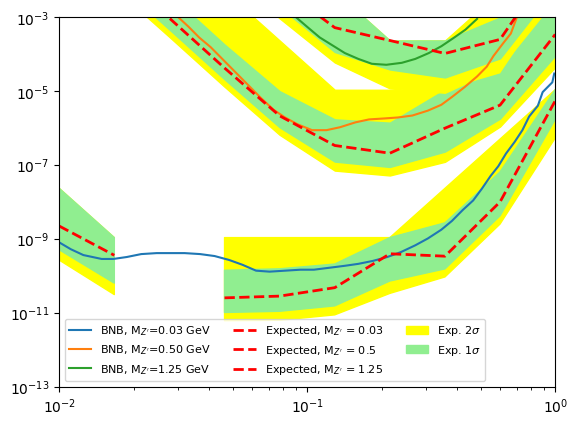

In [253]:
# Constrained background
plot_against_limits(limits_dict, mass_point_arr)

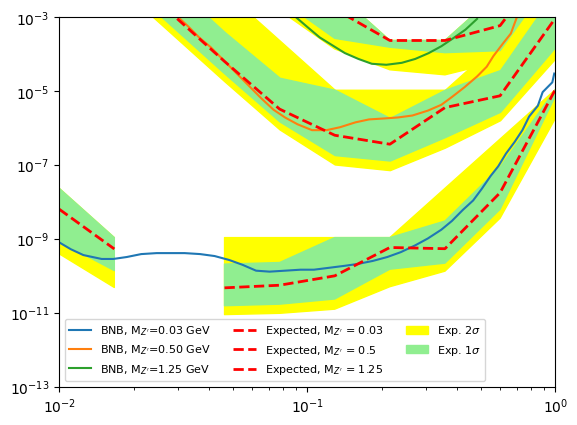

In [250]:
# Unconstrained background
plot_against_limits(limits_dict, mass_point_arr, )